<a href="https://colab.research.google.com/github/EldarEyvazov/Sentiment-Analysis-Amazon-Product/blob/main/NLP_project_Eldar_Eyvazov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing and downloading
import json
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install gensim
!pip install nltk
import nltk
from gensim.models import Word2Vec
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import joblib
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score
!pip install tensorflow
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('all')
nltk.download('stopwords')  # Stopwords list
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Lemmatizer dependencies
nltk.download('vader_lexicon')









[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

To run the notebook, please remove the google drive mounting part and use the dataset by running this code:

In [ ]:
# Load the dataset from the downloaded file
file_path = 'Reviews.csv'
df = pd.read_csv(file_path)

# Check the first few rows to understand the structure of the data
print(df.head())


In [ ]:
# Mount your Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Exploring the dataset

In [ ]:
# Load the dataset from the downloaded file
file_path = '/content/drive/My Drive/NLP/Reviews.csv'
df = pd.read_csv(file_path)

# Check the first few rows to understand the structure of the data
print(df.head())


   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [ ]:
# Display the column names
print(df.columns)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [ ]:
# Check for missing values
print(df.isnull().sum())

# Display the column names to understand the structure of our data
print(df.columns)


Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


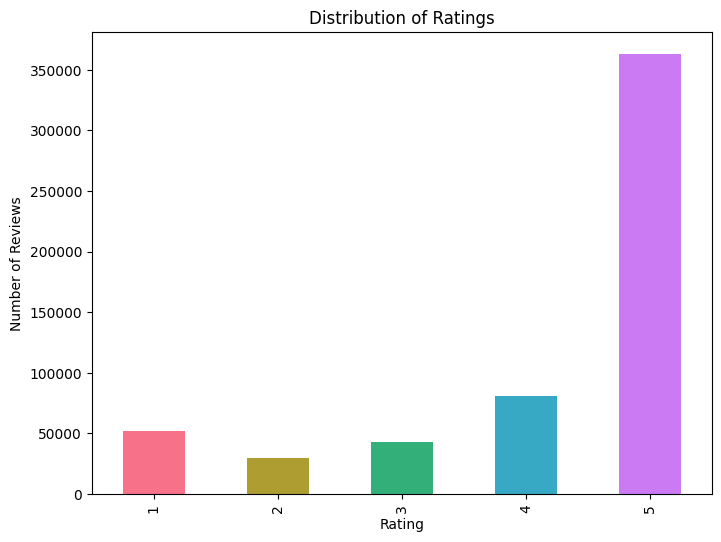

In [ ]:
# Set the color palette to use different colors for each bar
colors = sns.color_palette('husl', len(df['Score'].value_counts().sort_index()))

# Plot the distribution of ratings
plt.figure(figsize=(8,6))
bars = df['Score'].value_counts().sort_index().plot(kind='bar', color=colors)

plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Ratings')

# Show the plot
plt.show()


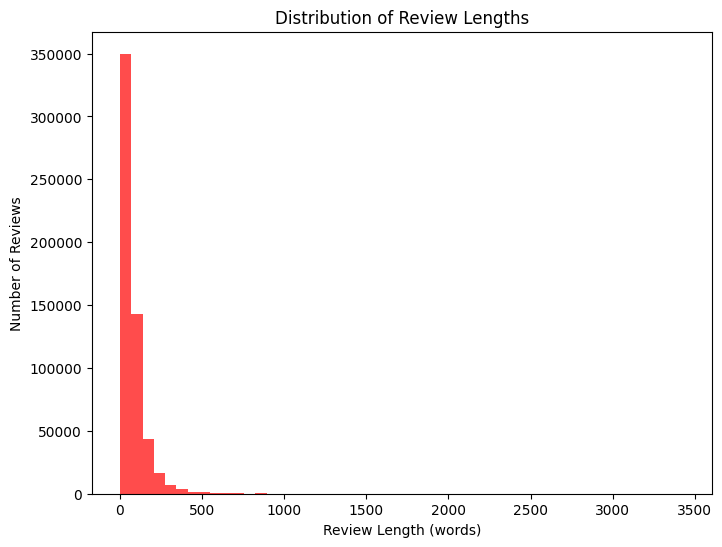

count    568454.000000
mean         80.264023
std          79.455384
min           3.000000
25%          33.000000
50%          56.000000
75%          98.000000
max        3432.000000
Name: review_length, dtype: float64


In [ ]:
# Calculate the length of each review
df['review_length'] = df['Text'].apply(lambda x: len(x.split()))

# Plot the distribution of review lengths
plt.figure(figsize=(8,6))
plt.hist(df['review_length'], bins=50, color='red', alpha=0.7)
plt.xlabel('Review Length (words)')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Review Lengths')
plt.show()

# Summary statistics of review lengths
print(df['review_length'].describe())


In [ ]:
# Create a new DataFrame with the relevant columns
rating_df = pd.DataFrame(df, columns=['Score', 'Text', 'Summary', 'HelpfulnessNumerator', 'HelpfulnessDenominator'])

# Function to map scores to sentiment labels
def map_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score <= 2:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment mapping to the 'Score' column
rating_df['Sentiment'] = rating_df['Score'].apply(map_sentiment)

# Display the first few rows of the updated DataFrame
rating_df.head()


,Score,Text,Summary,HelpfulnessNumerator,HelpfulnessDenominator,Sentiment
0,5,I have bought several of the Vitality canned d...,Good Quality Dog Food,1,1,Positive
1,1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,0,0,Negative
2,4,This is a confection that has been around a fe...,"""Delight"" says it all",1,1,Positive
3,2,If you are looking for the secret ingredient i...,Cough Medicine,3,3,Negative
4,5,Great taffy at a great price. There was a wid...,Great taffy,0,0,Positive


In [ ]:
# Delete rows where 'Summary' or 'Text' columns have NaN values
rating_df = rating_df.dropna(subset=['Summary', 'Text'])

# Concatenate 'Summary' and 'Text' into a new column 'combined_text'
rating_df['combined_text'] = rating_df['Summary'] + ' ' + rating_df['Text']

# Check the first few rows to verify the concatenation
rating_df.head()


,Score,Text,Summary,HelpfulnessNumerator,HelpfulnessDenominator,Sentiment,combined_text
0,5,I have bought several of the Vitality canned d...,Good Quality Dog Food,1,1,Positive,Good Quality Dog Food I have bought several of...
1,1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,0,0,Negative,Not as Advertised Product arrived labeled as J...
2,4,This is a confection that has been around a fe...,"""Delight"" says it all",1,1,Positive,"""Delight"" says it all This is a confection tha..."
3,2,If you are looking for the secret ingredient i...,Cough Medicine,3,3,Negative,Cough Medicine If you are looking for the secr...
4,5,Great taffy at a great price. There was a wid...,Great taffy,0,0,Positive,Great taffy Great taffy at a great price. The...


In [ ]:
# Verify the change by checking if there are any NaN values left
print(rating_df['combined_text'].isnull().sum())  # We should get output 0, if it is performed correctly


0


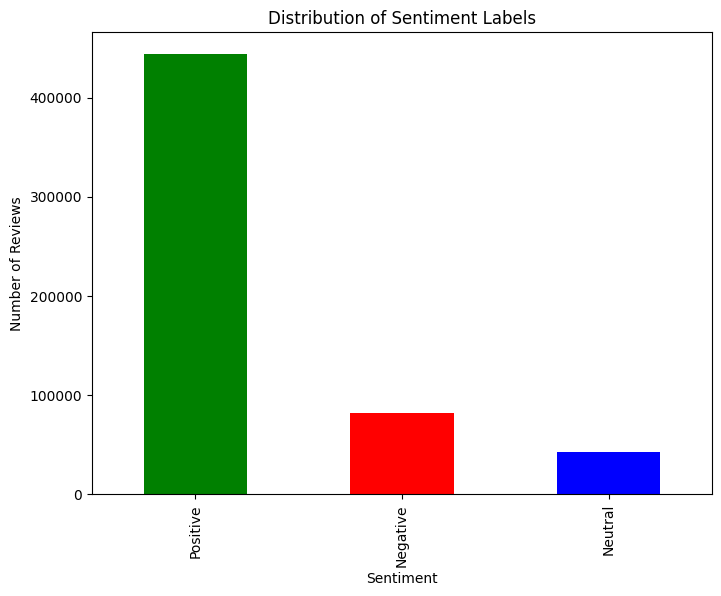

Sentiment
Positive    443777
Negative     82012
Neutral      42638
Name: count, dtype: int64


In [ ]:
# Count the number of occurrences of each sentiment category
sentiment_counts = rating_df['Sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8,6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiment Labels')
plt.show()
print(sentiment_counts)

# Text Preprocessing

Our initial step involves converting all text to lowercase to ensure consistency in preprocessing.

The project aims to analyze classical machine learning algorithms as a foundational approach, followed by the development of advanced deep learning models. Since our focus initially lies on classical machine learning methods, we will employ the TF-IDF representation, as these models do not emphasize semantic relationships between words. In subsequent phases, we will explore more sophisticated techniques tailored to deep learning models.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

# Preprocessing function: cleaning, tokenizing, stopword removal, lemmatizing, and removing special characters
def preprocess_text(text):
    # Step 1: Lowercase the text
    text = text.lower()

    # Step 2: Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Step 3: Tokenize the text
    tokens = word_tokenize(text)

    # Step 4: Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # Step 5: Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Step 6: Join lemmatized tokens back into a string
    return ' '.join(lemmatized_tokens)

# Apply the preprocessing function to the 'combined_text' column
rating_df['combined_text'] = rating_df['combined_text'].apply(preprocess_text)

# Display the first few rows to verify changes
print(rating_df[['combined_text']].head(10))


                                       combined_text
0  good quality dog food bought several vitality ...
1  advertised product arrived labeled jumbo salte...
2  delight say confection around century light pi...
3  cough medicine looking secret ingredient robit...
4  great taffy great taffy great price wide assor...
5  nice taffy got wild hair taffy ordered five po...
6  great good expensive brand saltwater taffy gre...
7  wonderful tasty taffy taffy good soft chewy fl...
8  yay barley right im mostly sprouting cat eat g...
9  healthy dog food healthy dog food good digesti...


In [ ]:
# Display 10 full examples from the 'combined_text' column to inspect
for i, row in rating_df['combined_text'].head(10).items():
    print(f"Example {i+1}: {' '.join(row) if isinstance(row, list) else row}\n")


Example 1: good quality dog food bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better

Example 2: advertised product arrived labeled jumbo salted peanutsthe peanut actually small sized unsalted sure error vendor intended represent product jumbo

Example 3: delight say confection around century light pillowy citrus gelatin nut case filbert cut tiny square liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sister witch

Example 4: cough medicine looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal

Example 5: great taffy great taffy great price wide assortment yummy taffy delivery quick taffy lover deal

Example 6: nice taffy got wild hair taffy ordered five pound bag taffy enjoyab

# Helper Functions

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def create_models_folder(base_path):
    """Create a 'models' folder under the given base path if it doesn't exist."""
    models_folder_path = os.path.join(base_path, 'models')
    if not os.path.exists(models_folder_path):
        os.makedirs(models_folder_path)
        print(f"Created 'models' folder at: {models_folder_path}")
    else:
        print(f"'models' folder already exists at: {models_folder_path}")
    return models_folder_path


def save_model_global(model, model_name, base_path):
    """Save the trained model to the 'models' folder with a filename based on the model's name."""
    # Create the models folder
    models_folder_path = create_models_folder(base_path)

    # Define the full file path
    file_path = os.path.join(models_folder_path, f"{model_name}.joblib")

    # Save the model
    joblib.dump(model, file_path)
    print(f"Model '{model_name}' saved to: {file_path}")

# Step 2: Base path for NLP folder in Google Drive
base_path = '/content/drive/My Drive/NLP'


def load_saved_model(model_name, base_path):
    """Load a model from the 'models' folder in Google Drive."""
    models_folder_path = os.path.join(base_path, 'models')
    file_path = os.path.join(models_folder_path, f"{model_name}.joblib")

    if os.path.exists(file_path):
        model = joblib.load(file_path)
        print(f"Model '{model_name}' loaded from: {file_path}")
        return model
    else:
        print(f"Model '{model_name}' not found at: {file_path}")
        return None


def save_model_global(model, model_name, base_path):
    """Save the trained model to the 'models' folder with a filename based on the model's name."""
    models_folder_path = create_models_folder(base_path)
    file_path = os.path.join(models_folder_path, f"{model_name}.joblib")
    joblib.dump(model, file_path)
    print(f"Model '{model_name}' saved to: {file_path}")

def save_model_weights(model, model_name, base_path):
    """Save the model weights to the 'models' folder with the .weights.h5 extension."""
    models_folder_path = create_models_folder(base_path)
    weights_path = os.path.join(models_folder_path, f"{model_name}.weights.h5")
    model.save_weights(weights_path)
    print(f"Weights for model '{model_name}' saved to: {weights_path}")

def save_training_history(history, model_name, base_path):
    """Save the training history to a file."""
    models_folder_path = create_models_folder(base_path)
    history_path = os.path.join(models_folder_path, f"{model_name}_history.joblib")
    joblib.dump(history.history, history_path)
    print(f"Training history for model '{model_name}' saved to: {history_path}")


def calculate_accuracy(y_true, y_pred):
    """Calculate and return the accuracy score."""
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy


def calculate_metrics(y_true, y_pred):
    """Calculate precision, recall, and F1 score."""
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return precision, recall, f1



def plot_confusion_matrix(y_true, y_pred, labels):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()







In [ ]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, base_path):
    """
    Train the model, save it if not already saved, and evaluate performance on both validation and test sets.

    Parameters:
    model (sklearn model): The machine learning model to train.
    X_train (sparse matrix): The training data features.
    y_train (array): The training data labels.
    X_val (sparse matrix): The validation data features.
    y_val (array): The validation data labels.
    X_test (sparse matrix): The test data features.
    y_test (array): The test data labels.
    model_name (str): The name of the model for saving and loading.
    base_path (str): The base path where the model will be saved and loaded from.

    Returns:
    dict: A dictionary containing validation and test metrics.
    """

    # Load the model if it already exists, to avoid re-training
    loaded_model = load_saved_model(model_name, base_path)

    if loaded_model is not None:
        model = loaded_model
        print("Using the loaded model without retraining.")
    else:
        # Train the model if it doesn't exist
        print("Training the model...")
        model.fit(X_train, y_train)

        # Save the trained model
        save_model_global(model, model_name, base_path)

    # Predict on the validation set
    y_val_pred = model.predict(X_val)

    # Predict on the test set
    y_test_pred = model.predict(X_test)

    # Calculate and print validation metrics
    print(f"\nValidation Set Performance for {model_name}:")
    val_accuracy = accuracy_score(y_val, y_val_pred)


    # Calculate and print test metrics
    print(f"\nTest Set Performance for {model_name}:")
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print("Classification Report (Test Set):\n", classification_report(y_test, y_test_pred))

    # Plot the confusion matrix for the test set
    labels = np.unique(np.concatenate([y_train, y_val, y_test]))  # Get unique labels from all sets
    plot_confusion_matrix(y_test, y_test_pred, labels=labels)

    # Return a dictionary of the metrics for further analysis
    return {
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'val_classification_report': classification_report(y_val, y_val_pred, output_dict=True),
        'test_classification_report': classification_report(y_test, y_test_pred, output_dict=True),
        'val_predictions': y_val_pred,
        'test_predictions': y_test_pred
    }


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Ensure combined_text is cleaned and all entries are strings
# If the combined_text is in list form, join them into a single string
rating_df['combined_text'] = rating_df['combined_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Step 2: Remove rows where the 'combined_text' column is empty or contains only spaces
rating_df = rating_df[rating_df['combined_text'].str.strip() != '']

# Step 3: Initialize the TF-IDF Vectorizer with unigrams and bigrams
tfidf_vectorizer_uni_bigrams = TfidfVectorizer(ngram_range=(1, 2))

# Step 4: Apply the TF-IDF vectorizer to the cleaned 'combined_text' column
tfidf_matrix_uni_bigrams = tfidf_vectorizer_uni_bigrams.fit_transform(rating_df['combined_text'])

# Step 5: Output the shape of the resulting matrix to verify
print(f'TF-IDF matrix shape: {tfidf_matrix_uni_bigrams.shape}')


TF-IDF matrix shape: (568427, 4703171)


In [ ]:
# Step 1: we ensure that
y_encoded = rating_df['Sentiment'] #y contains 3 labels "Positive", "Negative", "Neutral"

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_uni_bigrams, y_encoded, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


print(y_encoded)




0         Positive
1         Negative
2         Positive
3         Negative
4         Positive
            ...   
568449    Positive
568450    Negative
568451    Positive
568452    Positive
568453    Positive
Name: Sentiment, Length: 568427, dtype: object


# Feature Extraction

For classical machine learning algorithms, we plan to utilize TF-IDF with n-grams instead of the standard TF-IDF, as preserving word order is crucial for sentiment analysis. While we may conduct a comparative analysis between TF-IDF and TF-IDF with n-grams, we anticipate that incorporating n-grams will improve model performance. As we transition to advanced deep learning models, we will explore various feature extraction techniques to further optimize results.

**Preparing the data and Modelling**

In [ ]:
# Step 1: Ensure combined_text is cleaned and all entries are strings
# If the combined_text is in list form, join them into a single string
rating_df['combined_text'] = rating_df['combined_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Step 2: Remove rows where the 'combined_text' column is empty or contains only spaces
rating_df = rating_df[rating_df['combined_text'].str.strip() != '']

# Step 3: Initialize the TF-IDF Vectorizer with unigrams and bigrams
tfidf_vectorizer_uni_bigrams = TfidfVectorizer(ngram_range=(1, 2))

# Step 4: Apply the TF-IDF vectorizer to the cleaned 'combined_text' column
tfidf_matrix_uni_bigrams = tfidf_vectorizer_uni_bigrams.fit_transform(rating_df['combined_text'])

# Step 5: Output the shape of the resulting matrix to verify
print(f'TF-IDF matrix shape: {tfidf_matrix_uni_bigrams.shape}')


TF-IDF matrix shape: (568427, 4703171)


Model 'logreg_multiclass_new' loaded from: /content/drive/My Drive/NLP/models/logreg_multiclass_new.joblib
Using the loaded model without retraining.

Validation Set Performance for logreg_multiclass_new:

Test Set Performance for logreg_multiclass_new:
Classification Report (Test Set):
               precision    recall  f1-score   support

    Negative       0.86      0.79      0.82     16301
     Neutral       0.79      0.40      0.53      8434
    Positive       0.93      0.99      0.96     88951

    accuracy                           0.91    113686
   macro avg       0.86      0.73      0.77    113686
weighted avg       0.91      0.91      0.91    113686



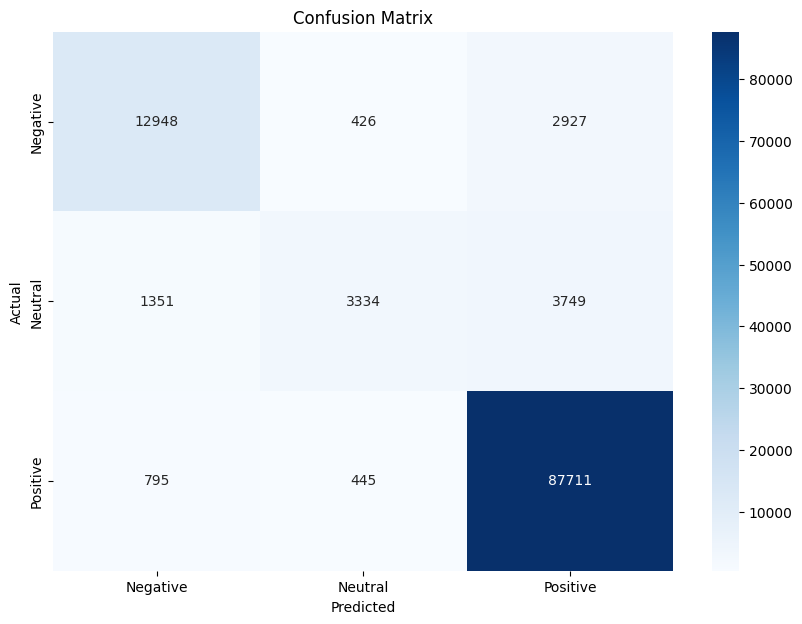

In [ ]:
logreg_model = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')

metrics = train_and_evaluate_model(
    logreg_model,
    X_train, y_train,  # Training data
    X_val, y_val,      # Validation data
    X_test, y_test,    # Test data
    model_name="logreg_multiclass_new",
    base_path='/content/drive/My Drive/NLP'
)



Although the model achieves an impressive 91% accuracy, this metric is heavily influenced by class imbalance, as the large proportion of positive samples skews the results. The model performs exceptionally well on positive sentiments (F1: 0.96), but it struggles significantly with neutral sentiments (F1: 0.53), primarily due to low recall (40%). Negative sentiments are handled reasonably well (F1: 0.82), though the recall (79%) suggests there is still room for improvement. Therefore, while the high accuracy is encouraging, it should be interpreted with caution, given the imbalanced nature of the dataset, which limits the model's ability to generalize across all sentiment classes. To address this issue, our next step will focus on mitigating the class imbalance by calculating class weights and adjusting them manually to improve performance, particularly on the neutral class.

In [ ]:
# Step 1: Calculate class frequencies
class_counts = Counter(y_train)
total_samples = len(y_train)

# Step 2: Calculate class weights (inverse of class frequency)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}


# Step 3: Normalize the weights (optional)
sum_weights = sum(class_weights.values())
class_weights = {cls: weight / sum_weights * len(class_weights) for cls, weight in class_weights.items()}

# Display class weights
print("Class Weights:", class_weights)

Class Weights: {'Negative': 0.9650967855263546, 'Positive': 0.17887789901883833, 'Neutral': 1.8560253154548074}


Model 'logreg_multiclass_weighted_new_1' loaded from: /content/drive/My Drive/NLP/models/logreg_multiclass_weighted_new_1.joblib
Using the loaded model without retraining.

Validation Set Performance for logreg_multiclass_weighted_new_1:

Test Set Performance for logreg_multiclass_weighted_new_1:
Classification Report (Test Set):
               precision    recall  f1-score   support

    Negative       0.86      0.79      0.82     16301
     Neutral       0.79      0.40      0.53      8434
    Positive       0.93      0.99      0.96     88951

    accuracy                           0.91    113686
   macro avg       0.86      0.73      0.77    113686
weighted avg       0.91      0.91      0.91    113686



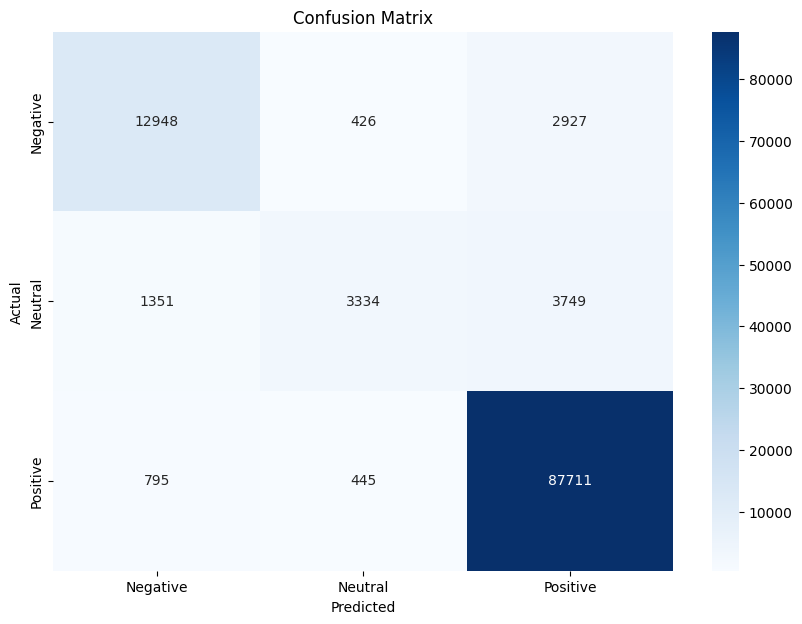

In [ ]:
#Step 3: Train a Logistic Regression model with the specified class weights
logreg_model_weighted = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs', class_weight=class_weights)


# Call the train_and_evaluate_model function
metrics = train_and_evaluate_model(
    logreg_model,           # The Logistic Regression model you trained
    X_train, y_train,       # Updated: Training subset
    X_val, y_val,           # Validation set for tuning and evaluation
    X_test, y_test,         # Test set for final evaluation
    model_name='logreg_multiclass_weighted_new_1',  # Model name
    base_path=base_path     # Base path to save/load model
)

The application of class weights did not significantly improve the model's performance, especially for the Neutral class, which still has low recall (0.40) and F1-score (0.53). Performance for the Negative and Positive classes remained stable, with no noticeable change in precision, recall, or F1-score. The overall accuracy and weighted averages were unaffected. This suggests that while class weights did not improve performance, additional techniques might be used later on. However, since these traditional Machine Learning Algorithms serve as baseline models of this project, we are not going to dive too much into performance seeking.


# Download Glove

In [ ]:
import os
import urllib.request
import zipfile

def download_glove(destination_folder, glove_file='glove.6B.100d.txt'):
    """Download GloVe embeddings if they are not already in the destination folder."""

    glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
    glove_zip_path = os.path.join(destination_folder, "glove.6B.zip")
    glove_file_path = os.path.join(destination_folder, glove_file)

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Download the GloVe embeddings zip file
    if not os.path.exists(glove_file_path):
        print("Downloading GloVe embeddings...")
        urllib.request.urlretrieve(glove_url, glove_zip_path)
        print("GloVe embeddings downloaded successfully.")

        # Extract the zip file
        with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
            print("Extracting GloVe embeddings...")
            zip_ref.extractall(destination_folder)
            print("GloVe embeddings extracted successfully.")
    else:
        print(f"{glove_file} already exists in {destination_folder}. Skipping download.")

# Specify the destination folder and file name for GloVe
destination_folder = './glove'
glove_file = 'glove.6B.100d.txt'

# Call the function to download GloVe
download_glove(destination_folder, glove_file)


GloVe embeddings downloaded successfully.
Extracting GloVe embeddings...
GloVe embeddings extracted successfully.


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Load the GloVe embeddings into a dictionary (glove_embeddings_index)
def load_glove_embeddings(glove_file_path):
    """Load GloVe embeddings from a file into a dictionary."""
    glove_embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings_index[word] = vector
    print(f"Loaded {len(glove_embeddings_index)} word vectors from GloVe.")
    return glove_embeddings_index

# Load the GloVe embeddings
glove_file_path = '/content/glove/glove.6B.100d.txt'
glove_embeddings_index = load_glove_embeddings(glove_file_path)

# Step 2: Create the embedding matrix using the tokenizer's word index and GloVe embeddings
def create_embedding_matrix(tokenizer, embedding_dim, glove_embeddings_index, max_words):
    """Create an embedding matrix using GloVe vectors for the tokenizer's vocabulary."""
    # Initialize the embedding matrix with zeros
    embedding_matrix = np.zeros((max_words, embedding_dim))

    # Loop through the tokenizer's word index and map each word to its GloVe vector
    for word, index in tokenizer.word_index.items():
        if index < max_words:
            embedding_vector = glove_embeddings_index.get(word)
            if embedding_vector is not None:
                # If the word is in GloVe, put its vector into the embedding matrix
                embedding_matrix[index] = embedding_vector

    return embedding_matrix

# Parameters
embedding_dim = 100  # Dimension of the GloVe vectors
max_words = 10000    # Limit the vocabulary size to 10,000 words

# Step 3: Tokenize the training data
texts = rating_df['combined_text'].tolist()  # Assuming this is your text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)  # Fit the tokenizer on the texts

# Step 4: Create the embedding matrix using the tokenizer from your training data
embedding_matrix_glove = create_embedding_matrix(tokenizer, embedding_dim, glove_embeddings_index, max_words)
print(f"Embedding matrix shape: {embedding_matrix_glove.shape}")


Loaded 400000 word vectors from GloVe.
Embedding matrix shape: (10000, 100)


In [ ]:
def load_training_history(model_name, base_path):
    history_path = os.path.join(base_path, 'models', f"{model_name}_history.pkl")
    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            history = pickle.load(f)
        return history
    else:
        print(f"No history file found for {model_name}.")
        return None

def train(model, model_name, base_path, X_train, y_train, X_val, y_val, learning_rate=1e-3, batch_size=32, epochs=50, force_train=False):
    history = None
    saved_model = load_saved_model(model_name, base_path)

    if saved_model and not force_train:
        print(f"Model '{model_name}' loaded successfully. Skipping training.")
        model = saved_model
        weights_path = os.path.join(base_path, 'models', f"{model_name}.weights.h5")
        if os.path.exists(weights_path):
            model.load_weights(weights_path)
            print(f"Weights for model '{model_name}' loaded from {weights_path}.")

        # Load training history if available
        history = load_training_history(model_name, base_path)
        if history:
            print(f"Training history for '{model_name}' loaded successfully.")
        else:
            print(f"No training history found for '{model_name}'.")

    else:
        print(f"Training new model: {model_name}")

        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[reduce_lr, early_stopping],
            verbose=1
        )

        save_model_global(model, model_name, base_path)
        save_model_weights(model, model_name, base_path)

        # Save training history
        with open(os.path.join(base_path, 'models', f"{model_name}_history.pkl"), 'wb') as f:
            pickle.dump(history.history, f)
        print(f"Model and training history for '{model_name}' saved successfully.")

    return model, history


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf


def evaluate(model, X_test, y_test, label_map):
    """
    Evaluate the trained model on the test set and plot confusion matrix.

    Args:
        model (keras.Model): The trained model to be evaluated.
        X_test (numpy array or tensor): Test input data.
        y_test (numpy array): Test target data (not one-hot encoded).
        label_map (dict): Mapping from labels (integers) to class names.

    Returns:
        None: Prints the evaluation metrics and confusion matrix.
    """
    # Ensure input is in tensor format
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

    # Ensure data and model are on the same device (GPU if available)
    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        # Make predictions
        y_test_pred = model.predict(X_test)

        # Get predicted classes (not one-hot encoded)
        y_test_pred_classes = y_test_pred.argmax(axis=1)  # Convert probabilities to class indices
        y_test_true_classes = y_test.numpy()  # Convert tensor to numpy array for comparison

        # Calculate precision, recall, F1 score, and accuracy
        precision_test = precision_score(y_test_true_classes, y_test_pred_classes, average='macro')
        recall_test = recall_score(y_test_true_classes, y_test_pred_classes, average='macro')
        f1_test = f1_score(y_test_true_classes, y_test_pred_classes, average='macro')
        test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)

        # Calculate the loss on the test set
        loss_test, _ = model.evaluate(X_test, y_test, verbose=0)  # Only retrieve the loss

        # Print the results
        print("------------*****************------------")
        print(f"Test Loss: {loss_test:.4f}")
        print(f"Test Precision: {precision_test:.4f}")
        print(f"Test Recall: {recall_test:.4f}")
        print(f"Test F1 Score: {f1_test:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Plot the confusion matrix
        plot_confusion_matrix(y_test_true_classes, y_test_pred_classes, labels=list(label_map.values()))


In [ ]:
def plot_loss(history, model_name):
    if isinstance(history, dict):  # Loaded history is a dictionary
        train_loss = history['loss']
        val_loss = history['val_loss']
    elif history is not None:  # Normal history object
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
    else:
        print(f"No history available for the model: {model_name}.")
        return

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss Curve for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000)  # Adjust this as needed
tokenizer.fit_on_texts(rating_df['combined_text'])  # Fit tokenizer on preprocessed text

# Convert preprocessed text into integer sequences
X_sequences = tokenizer.texts_to_sequences(rating_df['combined_text'])

# Set max_length for padding
max_length = 100  # Define a maximum length for your sequences

# Pad the sequences to ensure all sequences have the same length
X_padded = pad_sequences(X_sequences, maxlen=max_length)

# Now split the data
y = rating_df['Sentiment']  # Assuming 'Sentiment' contains your labels

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Split training data into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Check the split sizes and shapes
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (363792, 100)
Validation set size: (90949, 100)
Test set size: (113686, 100)


In [ ]:
# If your label_maps dictionary is already mapping string labels directly
label_maps = {
    'Positive': 0,
    'Neutral': 1,
    'Negative': 2
}

# Apply the label mapping by replacing string labels
y_train = [label_maps[label] for label in y_train]
y_val = [label_maps[label] for label in y_val]
y_test = [label_maps[label] for label in y_test]



In [ ]:
import tensorflow as tf
# Ensure X_train, X_val, and X_test are tensors of dtype float32
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Ensure y_train, y_val, y_test are tensors of dtype int32
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

# CNN

Here we are inspired by the approach described in paper "Convolutional Neural Networks for Sentiment Analysis on Weibo Data: A Natural Language Processing Approach":

By: Yufei Xie and Rodolfo C. Raga Jr


We start with our first shallow CNN model and see the performance

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Activation, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.initializers import Constant

def cnn(input_length, vocab_size, embedding_dim=50, num_classes=3):
    """
    Builds a CNN model based on the provided architecture using the Functional API.

    Args:
        input_length (int): Length of the input sequences.
        vocab_size (int): Size of the vocabulary for the Embedding layer.
        embedding_dim (int): Dimension of the embedding vectors. Default is 50.
        num_classes (int): Number of output classes. Default is 3.

    Returns:
        model (Model): Compiled CNN model.
    """
    # Input layer
    inputs = Input(shape=(input_length,))

    # Embedding layer (Using GloVe embeddings)
    x = Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=input_length,
                  embeddings_initializer=Constant(embedding_matrix_glove),  # Use GloVe embeddings here
                  trainable=False)(inputs)  # Set to False to freeze embeddings

    # Conv1D layer with Batch Normalization
    x = Conv1D(filters=128, kernel_size=2, activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)


    x = Dropout(0.4)(x)

    # Global average pooling layer
    x = GlobalAveragePooling1D()(x)

    # Dense layer
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)

    # Dropout layer
    x = Dropout(0.4)(x)

    # Activation layer
    x = Activation('relu')(x)

    # Output dense layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build the model
    model = Model(inputs=inputs, outputs=outputs)

    return model


In [ ]:
# Parameters for the model
input_length = 100  # Length of input sequences
vocab_size = 10000   # Vocabulary size
embedding_dim = 100  # Embedding dimensions
num_classes = 3     # Number of classes

# Build the model
model_cnn = cnn(input_length, vocab_size, embedding_dim, num_classes)

# Summary of the model
model_cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 99, 128)             │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 99, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 97, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 97, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 97, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053,443 (4.02 MB)

 Trainable params: 52,995 (207.01 KB)

 Non-trainable params: 1,000,448 (3.82 MB)

In [ ]:
import pickle
# Specify the model name and base path for saving/loading the model
model_name_cnn = "cnn_model_batch_size644"
base_path = "/content/drive/My Drive/NLP"



# Call the train function to train or load the model
cnn_model, history_cnn = train(model_cnn, model_name_cnn, base_path, X_train, y_train, X_val, y_val, learning_rate=1e-3, batch_size=64, epochs=150)


Model 'cnn_model_batch_size644' loaded from: /content/drive/My Drive/NLP/models/cnn_model_batch_size644.joblib
Model 'cnn_model_batch_size644' loaded successfully. Skipping training.
Weights for model 'cnn_model_batch_size644' loaded from /content/drive/My Drive/NLP/models/cnn_model_batch_size644.weights.h5.
Training history for 'cnn_model_batch_size644' loaded successfully.


3553/3553 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
------------*****************------------
Test Loss: 0.2719
Test Precision: 0.7951
Test Recall: 0.7233
Test F1 Score: 0.7479
Test Accuracy: 0.9064


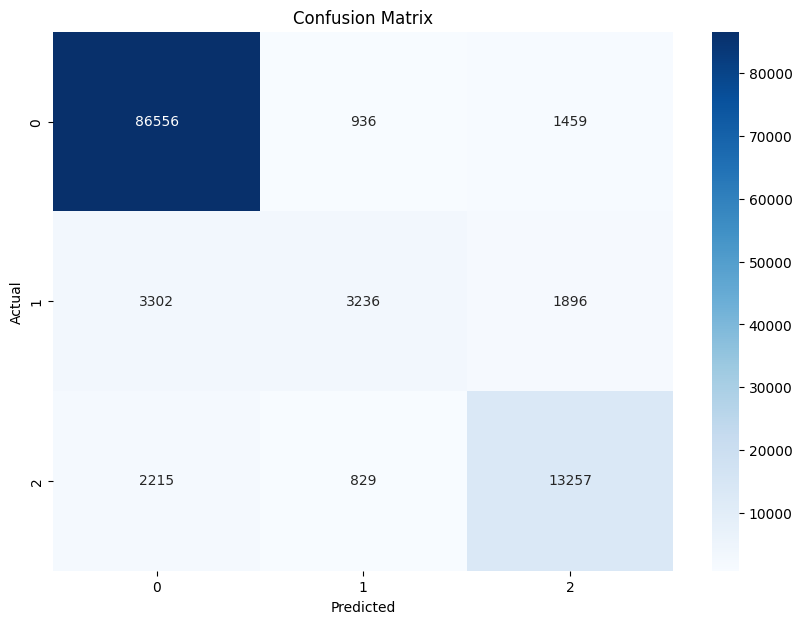

In [ ]:
evaluate(cnn_model, X_test, y_test, label_maps)


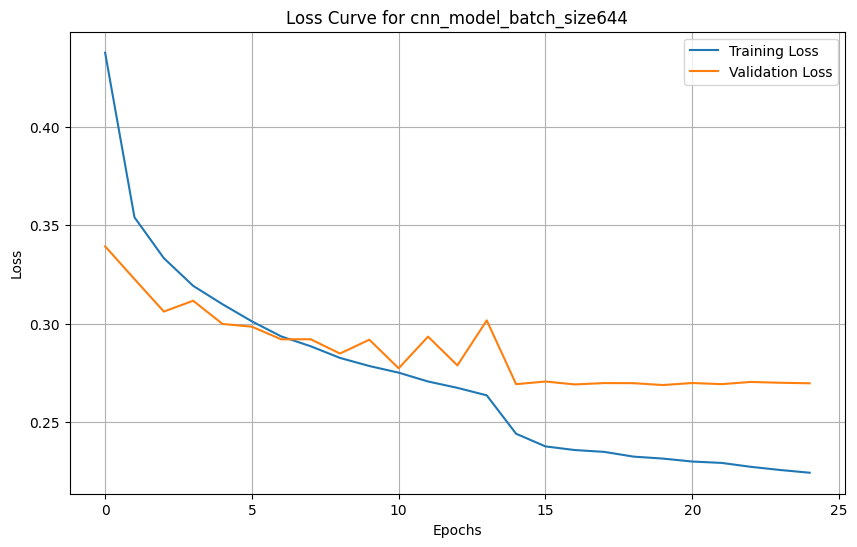

In [ ]:
plot_loss(history_cnn, model_name_cnn)

# LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, Input, BatchNormalization, GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant, GlorotUniform

def lstm_model(
    vocab_size,
    embedding_dim=100,
    input_length=None,
    embedding_matrix=None,
    lstm_units=[128, 64],
    dense_units=[16],
    dropout_rate=0.2
):
    # Input layer
    inputs = Input(shape=(input_length,))

    # Embedding Layer using GloVe embeddings
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=input_length,
        embeddings_initializer=Constant(embedding_matrix),  # GloVe embeddings
        trainable=False  # Set False as GloVe embeddings are not trainable
    )(inputs)

    # LSTM Layer 1
    lstm_layer_1 = LSTM(
        lstm_units[0],
        activation='tanh',
        return_sequences=True,  # Output sequences for further processing
        kernel_initializer=GlorotUniform()
    )(embedding_layer)
    lstm_layer_1 = Dropout(dropout_rate)(lstm_layer_1)
    lstm_layer_1 = BatchNormalization()(lstm_layer_1)

    # LSTM Layer 2
    lstm_layer_2 = LSTM(
        lstm_units[1],
        activation='tanh',
        return_sequences=True,  # Retain sequences for Global Pooling
        kernel_initializer=GlorotUniform()
    )(lstm_layer_1)
    lstm_layer_2 = Dropout(dropout_rate)(lstm_layer_2)
    lstm_layer_2 = BatchNormalization()(lstm_layer_2)

    # Global Average Pooling Layer
    x = GlobalAveragePooling1D()(lstm_layer_2)

    # Dense Layers
    x = Dense(dense_units[0], activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(dense_units[0], activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # Output Layer
    outputs = Dense(3, activation='softmax')(x)

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)

    return model


In [ ]:
lstm_model_glove = lstm_model(vocab_size, embedding_dim, input_length, embedding_matrix_glove)
lstm_model_glove.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_8 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 100, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 100, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 100, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,168,787 (4.46 MB)

 Trainable params: 168,403 (657.82 KB)

 Non-trainable params: 1,000,384 (3.82 MB)

In [ ]:
# Specify the model name and base path for saving/loading the model
model_name_lstm = "lstm_model_glove_128-64_"
base_path = "/content/drive/My Drive/NLP"  # Change to your directory path



# Call the train function to train or load the model
lstm_model_glove, history_bilstm = train(lstm_model_glove, model_name_lstm, base_path, X_train, y_train, X_val, y_val, learning_rate=1e-3, batch_size=128, epochs=70)


Model 'lstm_model_glove_128-64_' not found at: /content/drive/My Drive/NLP/models/lstm_model_glove_128-64_.joblib
Training new model: lstm_model_glove_128-64_
Epoch 1/70
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - accuracy: 0.8288 - loss: 0.4779 - val_accuracy: 0.8756 - val_loss: 0.3371 - learning_rate: 0.0010
Epoch 2/70
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.8715 - loss: 0.3521 - val_accuracy: 0.8845 - val_loss: 0.3109 - learning_rate: 0.0010
Epoch 3/70
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.8817 - loss: 0.3252 - val_accuracy: 0.8852 - val_loss: 0.3084 - learning_rate: 0.0010
Epoch 4/70
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.8875 - loss: 0.3058 - val_accuracy: 0.8905 - val_loss: 0.2937 - learning_rate: 0.0010
Epoch 5/70
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8925 - loss: 0.2913 - val_accuracy: 0.8928 - val_loss: 0.2878 - learning_rate: 0.0010
Epoch 6/70
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - acc

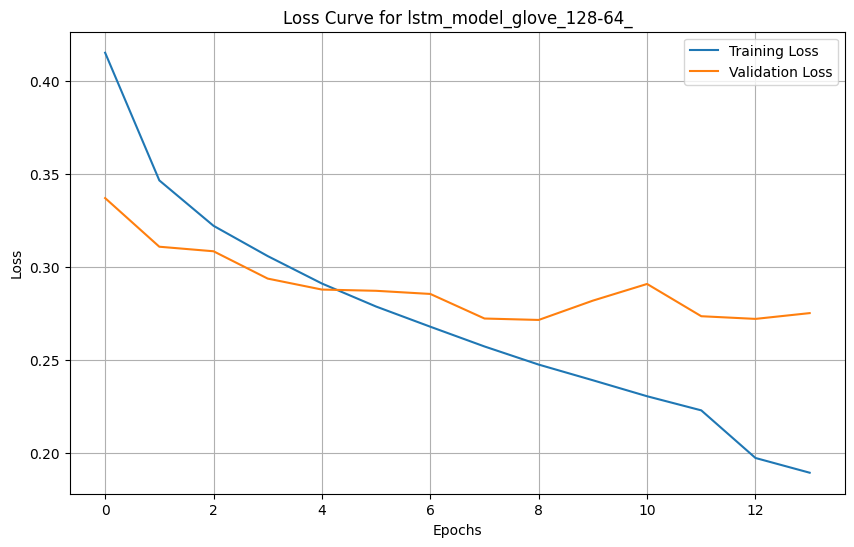

In [ ]:
plot_loss(history_bilstm, model_name_lstm)

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step
------------*****************------------
Test Loss: 0.2728
Test Precision: 0.7776
Test Recall: 0.7177
Test F1 Score: 0.7438
Test Accuracy: 0.9028


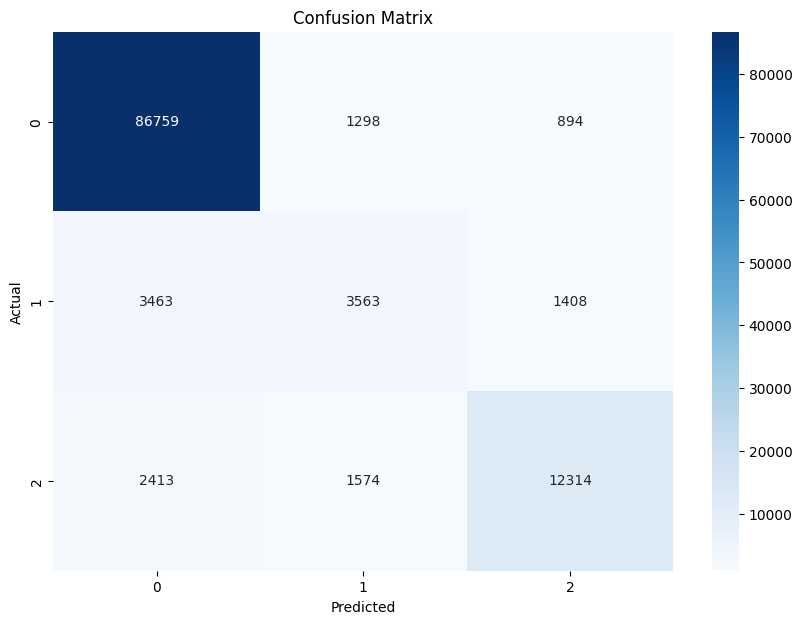

In [ ]:
evaluate(lstm_model_glove, X_test, y_test, label_maps)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input, GlobalAveragePooling1D
from tensorflow.keras.initializers import Constant, GlorotUniform
from tensorflow.keras.models import Model

def bilstm_model(
    vocab_size,
    embedding_dim=100,
    input_length=None,
    embedding_matrix=None,
    lstm_units=[100, 64],
    dense_units=[32],
    dropout_rate=0.5
):
    # Input layer
    inputs = Input(shape=(input_length,))

    # Embedding layer (Assumes embedding_matrix is always provided)
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=input_length,
        trainable=False  # GloVe embeddings are not trainable
    )(inputs)

    # BiLSTM layer 1 (return_sequences=True for passing to the next LSTM layer)
    lstm_layer_1 = Bidirectional(
        LSTM(
            lstm_units[0],
            activation='tanh',
            return_sequences=True,  # Keep sequences for the next LSTM layer
            kernel_initializer=GlorotUniform()
        )
    )(embedding_layer)

    # BiLSTM layer 2 (return_sequences=False for pooling layer)
    lstm_layer_2 = Bidirectional(
        LSTM(
            lstm_units[1],
            activation='tanh',
            return_sequences=False,  # Final LSTM output
            kernel_initializer=GlorotUniform()
        )
    )(lstm_layer_1)

    # Global Average Pooling layer
    x = lstm_layer_2

    # Dense layers
    for units in dense_units:
        x = Dense(units, activation='relu', kernel_initializer=GlorotUniform())(x)
        x = Dropout(dropout_rate)(x)

    # Output layer
    outputs = Dense(3, activation='softmax', kernel_initializer=GlorotUniform())(x)

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)

    return model


In [ ]:
input_length = 100  # Length of input sequences
vocab_size = 10000   # Vocabulary size
embedding_dim = 100  # Embedding dimensions
num_classes = 3     # Number of classes

In [ ]:
bilstm_model_train_emb = bilstm_model(vocab_size, embedding_dim, input_length, embedding_matrix_glove)
bilstm_model_train_emb.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_17 (Embedding)             │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 100, 200)            │         160,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 128)                 │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,300,707 (4.96 MB)

 Trainable params: 300,707 (1.15 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
# Specify the model name and base path for saving/loading the model
model_name_bilstm = "bilstm_model_GloVe_128_64"
base_path = "/content/drive/My Drive/NLP"
# Call the train function to train or load the model
bilstm_model_train_emb, history_bilstm = train(bilstm_model_train_emb, model_name_bilstm, base_path, X_train, y_train, X_val, y_val, learning_rate=1e-3, batch_size=128, epochs=40)


Model 'bilstm_model_GloVe_128_64' not found at: /content/drive/My Drive/NLP/models/bilstm_model_GloVe_128_64.joblib
Training new model: bilstm_model_GloVe_128_64
Epoch 1/40
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - accuracy: 0.8259 - loss: 0.4950 - val_accuracy: 0.8719 - val_loss: 0.3460 - learning_rate: 0.0010
Epoch 2/40
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - accuracy: 0.8717 - loss: 0.3512 - val_accuracy: 0.8846 - val_loss: 0.3110 - learning_rate: 0.0010
Epoch 3/40
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - accuracy: 0.8853 - loss: 0.3133 - val_accuracy: 0.8913 - val_loss: 0.2906 - learning_rate: 0.0010
Epoch 4/40
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - accuracy: 0.8967 - loss: 0.2798 - val_accuracy: 0.8956 - val_loss: 0.2820 - learning_rate: 0.0010
Epoch 5/40
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - accuracy: 0.9070 - loss: 0.2525 - val_accuracy: 0.9004 - val_loss: 0.2813 - learning_rate: 0.0010
Epoch 6/40
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - 

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step
------------*****************------------
Test Loss: 0.2725
Test Precision: 0.7906
Test Recall: 0.7175
Test F1 Score: 0.7427
Test Accuracy: 0.9053


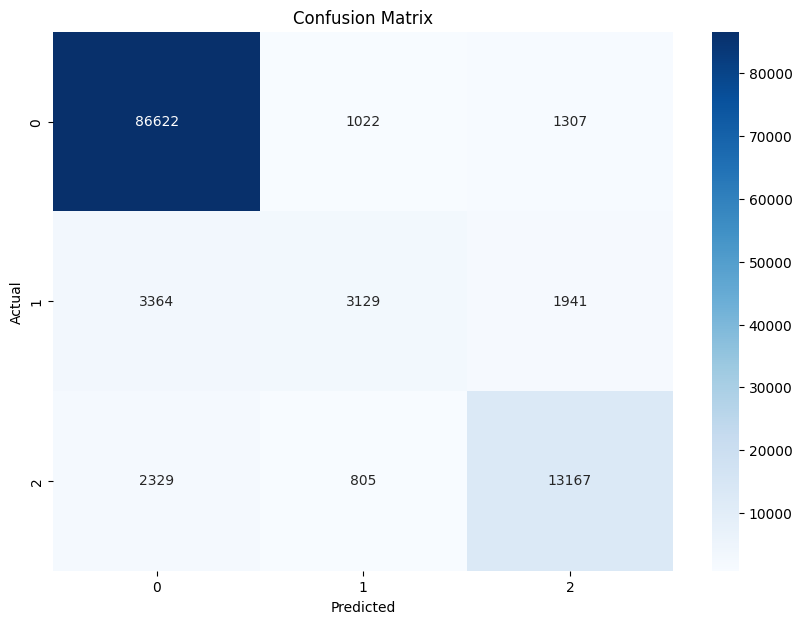

In [ ]:
evaluate(bilstm_model_train_emb, X_test, y_test, label_maps)

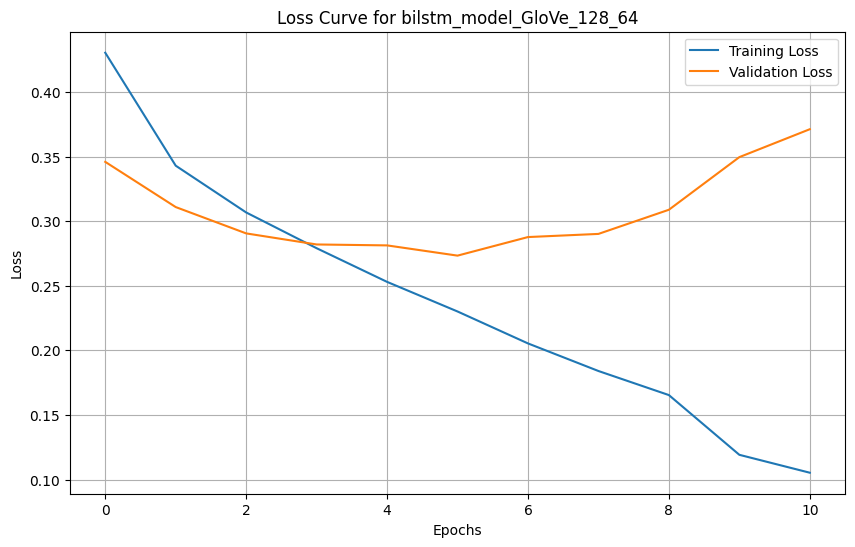

In [ ]:
plot_loss(history_bilstm, model_name_bilstm)

# Hybrid Model

In [ ]:
from keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Dropout, Dense, Flatten, Concatenate, Input, Bidirectional
from keras.models import Model
from keras.initializers import Constant

def hybrid_model(max_words, embedding_dim, max_length, num_classes, embedding_matrix_glove):
    """Build the Bidirectional LSTM + CNN model using GloVe embeddings."""

    # Input Layer
    input_layer = Input(shape=(max_length,))

    # Embedding Layer (using pre-trained GloVe embeddings)
    embedding_layer = Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix_glove),
        input_length=max_length,
        trainable=False  # GloVe embeddings are not trainable
    )(input_layer)

    # Apply dropout after embedding
    embedding_dropout = Dropout(0.5)(embedding_layer)

    # Bidirectional LSTM Layer
    lstm_layer = Bidirectional(LSTM(250, return_sequences=True))(embedding_dropout)

    # Convolutional Layers with different filter sizes
    conv_2 = Conv1D(filters=32, kernel_size=2, activation='relu')(lstm_layer)
    conv_3 = Conv1D(filters=32, kernel_size=3, activation='relu')(lstm_layer)


    # MaxPooling Layers
    pool_2 = MaxPooling1D(pool_size=2)(conv_2)
    pool_3 = MaxPooling1D(pool_size=2)(conv_3)


    # Flatten the outputs
    flat_2 = Flatten()(pool_2)
    flat_3 = Flatten()(pool_3)


    # Concatenate the flattened outputs
    concatenated = Concatenate()([flat_2, flat_3])

    # Dropout Layer to prevent overfitting
    dropout = Dropout(0.5)(concatenated)

    # Fully Connected Dense Layer
    dense = Dense(128, activation='relu')(dropout)

    # Output Layer (Softmax activation for multi-class classification)
    output_layer = Dense(num_classes, activation='softmax')(dense)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model


In [ ]:
# Build the model
lstm_cnn_250 = hybrid_model(vocab_size, embedding_dim, input_length, num_classes, embedding_matrix_glove)

# Display the model summary
lstm_cnn_250.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 100, 100)       │      1,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 100, 100)       │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 100, 500)       │        702,000 │ dropout_7[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 99, 32)         │         32,032 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 98, 32)         │         48,032 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 49, 32)         │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 49, 32)         │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1568)           │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 1568)           │              0 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3136)           │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 3136)           │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │        401,536 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 3)              │            387 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,183,987 (8.33 MB)

 Trainable params: 1,183,987 (4.52 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
# Specify the model name and base path for saving/loading the model
model_name_lstm_cnn_250 = "lstm_cnn_hybrid_"
base_path = "/content/drive/My Drive/NLP"

In [ ]:
lstm_cnn_trained_250, history_bilstm_cnn_250 = train(lstm_cnn_250, model_name_lstm_cnn_250, base_path, X_train, y_train, X_val, y_val, learning_rate=1e-3, batch_size=128, epochs=40)


Model 'lstm_cnn_hybrid_' not found at: /content/drive/My Drive/NLP/models/lstm_cnn_hybrid_.joblib
Training new model: lstm_cnn_hybrid_
Epoch 1/40
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 63s 21ms/step - accuracy: 0.8248 - loss: 0.4835 - val_accuracy: 0.8666 - val_loss: 0.3645 - learning_rate: 0.0010
Epoch 2/40
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 60s 21ms/step - accuracy: 0.8613 - loss: 0.3794 - val_accuracy: 0.8805 - val_loss: 0.3255 - learning_rate: 0.0010
Epoch 3/40
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 60s 21ms/step - accuracy: 0.8691 - loss: 0.3545 - val_accuracy: 0.8851 - val_loss: 0.3037 - learning_rate: 0.0010
Epoch 4/40
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 60s 21ms/step - accuracy: 0.8756 - loss: 0.3379 - val_accuracy: 0.8886 - val_loss: 0.3019 - learning_rate: 0.0010
Epoch 5/40
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 60s 21ms/step - accuracy: 0.8788 - loss: 0.3270 - val_accuracy: 0.8927 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 6/40
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 60s 21ms/step - accuracy: 0.8822 - loss: 0.

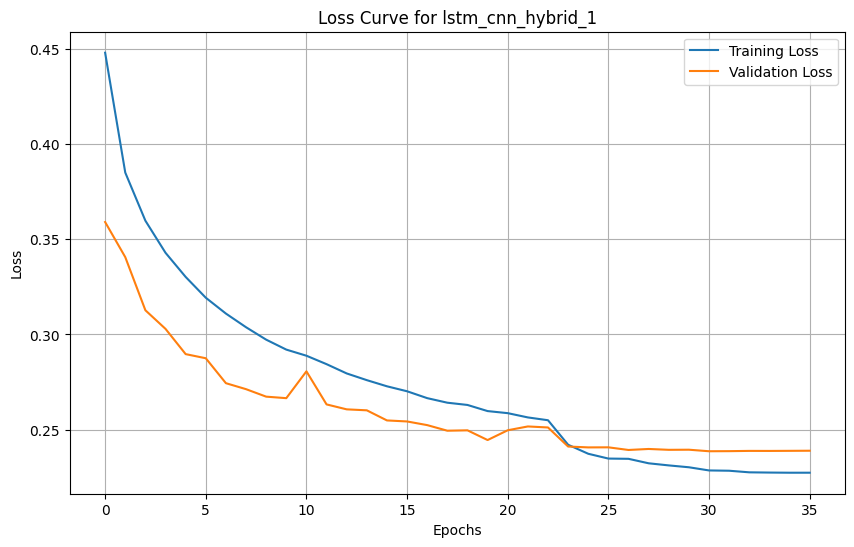

In [ ]:
plot_loss(history_bilstm_cnn_250,model_name_lstm_cnn_250)

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step
------------*****************------------
Test Loss: 0.2366
Test Precision: 0.8117
Test Recall: 0.7609
Test F1 Score: 0.7808
Test Accuracy: 0.9176


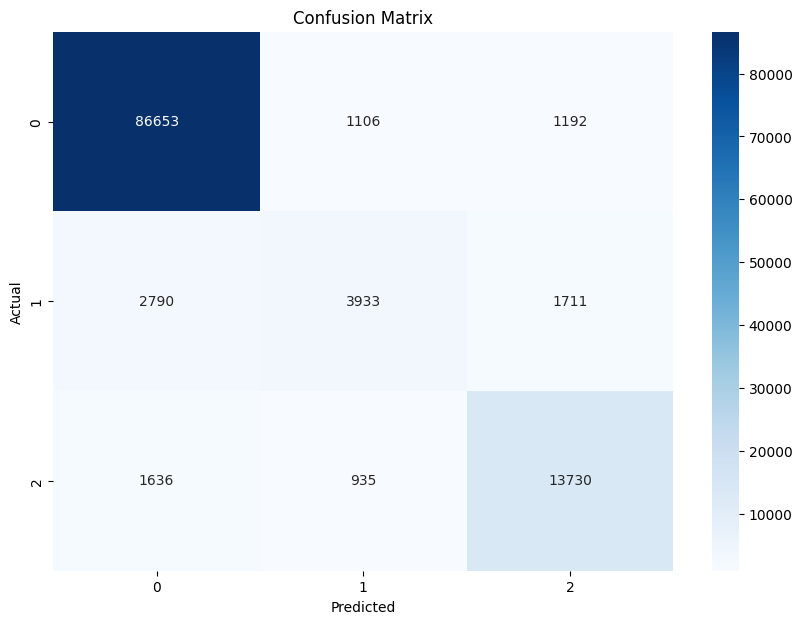

In [ ]:
evaluate(lstm_cnn_trained_250, X_test,y_test,label_maps)

# Oversampling

In [ ]:
pip install imbalanced-learn


In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

def resample_data(rating_df):
    # Step 1: Resample the dataset using RandomOverSampler
    X = rating_df['combined_text'].values.reshape(-1, 1)
    y = rating_df['Sentiment']

    ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Convert resampled data back to DataFrame
    resampled_df = pd.DataFrame(X_resampled.flatten(), columns=['combined_text'])
    resampled_df['Sentiment'] = y_resampled

    return resampled_df

resampled_df = resample_data(rating_df)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize_and_pad(resampled_df):
    # Step 3: Tokenization and padding
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(resampled_df['combined_text'])  # Fit tokenizer on preprocessed text

    # Convert preprocessed text into integer sequences
    X_sequences = tokenizer.texts_to_sequences(resampled_df['combined_text'])

    # Set max_length for padding
    max_length = 100  # Define a maximum length for your sequences

    # Pad the sequences to ensure all sequences have the same length
    X_padded = pad_sequences(X_sequences, maxlen=max_length)

    return X_padded, tokenizer



In [ ]:
from sklearn.model_selection import train_test_split

def split_data(X_padded, y):
    # Step 4: Split the data into training, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

    # Split training data into train and validation sets (80% train, 20% validation)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test




In [ ]:

# Display the first few rows of the DataFrame
print(resampled_df.head())

# Check the dimensions (rows and columns) of the DataFrame
print(f"Dimensions of resampled_df: {resampled_df.shape}")


                                       combined_text Sentiment
0  good quality dog food bought several vitality ...  Positive
1  advertised product arrived labeled jumbo salte...  Negative
2  delight say confection around century light pi...  Positive
3  cough medicine looking secret ingredient robit...  Negative
4  great taffy great taffy great price wide assor...  Positive
Dimensions of resampled_df: (1331331, 2)


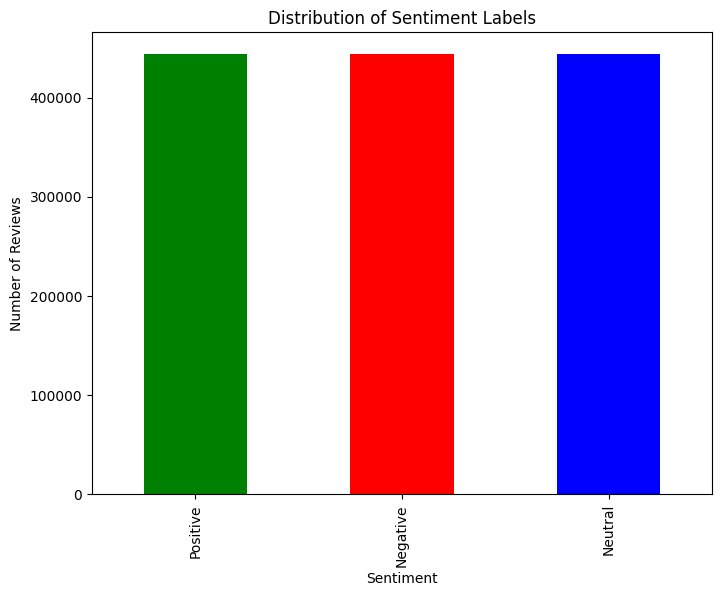

Sentiment
Positive    443777
Negative    443777
Neutral     443777
Name: count, dtype: int64


In [ ]:
# Count the number of occurrences of each sentiment category
sentiment_counts = resampled_df['Sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8,6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiment Labels')
plt.show()
print(sentiment_counts)

In [ ]:
# Step 2: Preprocess the text
resampled_df['combined_text'] = resampled_df['combined_text'].apply(preprocess_text)



In [ ]:
# Step 3: Tokenize and pad the text
X_padded_res, tokenizer = tokenize_and_pad(resampled_df)

# Step 4: Split the data into train, validation, and test sets
X_train_res, X_val_res, X_test_res, y_train_res, y_val_res, y_test_res = split_data(X_padded_res, resampled_df['Sentiment'])

# Print out the shapes of the data splits
print(f"Training set size: {X_train_res.shape}")
print(f"Validation set size: {X_val_res.shape}")
print(f"Test set size: {X_test_res.shape}")


Training set size: (852051, 100)
Validation set size: (213013, 100)
Test set size: (266267, 100)


In [ ]:
# If your label_maps dictionary is already mapping string labels directly
label_maps = {
    'Positive': 0,
    'Neutral': 1,
    'Negative': 2
}

# Apply the label mapping by replacing string labels
y_train_res = [label_maps[label] for label in y_train_res]
y_val_res = [label_maps[label] for label in y_val_res]
y_test_res = [label_maps[label] for label in y_test_res]

import tensorflow as tf
# Ensure X_train, X_val, and X_test are tensors of dtype float32
X_train_res = tf.convert_to_tensor(X_train_res, dtype=tf.float32)
X_val_res = tf.convert_to_tensor(X_val_res, dtype=tf.float32)
X_test_res = tf.convert_to_tensor(X_test_res, dtype=tf.float32)

# Ensure y_train, y_val, y_test are tensors of dtype int32
y_train_res = tf.convert_to_tensor(y_train_res, dtype=tf.int32)
y_val_res = tf.convert_to_tensor(y_val_res, dtype=tf.int32)
y_test_res = tf.convert_to_tensor(y_test_res, dtype=tf.int32)

# CNN model on oversampled

Training on oversampled dataset shows that, model we have trained on original dataset, remains sligthly simple so we need to increase the complexity.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Activation, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.initializers import Constant

def cnn_deeper(input_length, vocab_size, embedding_dim=50, num_classes=3):
    """
    Builds a CNN model based on the provided architecture using the Functional API.

    Args:
        input_length (int): Length of the input sequences.
        vocab_size (int): Size of the vocabulary for the Embedding layer.
        embedding_dim (int): Dimension of the embedding vectors. Default is 50.
        num_classes (int): Number of output classes. Default is 3.

    Returns:
        model (Model): Compiled CNN model.
    """
    # Input layer
    inputs = Input(shape=(input_length,))

    # Embedding layer (Using GloVe embeddings)
    x = Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=input_length,
                  embeddings_initializer=Constant(embedding_matrix_glove),  # Use GloVe embeddings here
                  trainable=False)(inputs)  # Set to False to freeze embeddings

    # Conv1D layer with Batch Normalization
    x = Conv1D(filters=256, kernel_size=2, activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = BatchNormalization()(x)


    x = Dropout(0.4)(x)

    # Global average pooling layer
    x = GlobalAveragePooling1D()(x)

    # Dense layer
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)

    # Dropout layer
    x = Dropout(0.4)(x)

    # Activation layer
    x = Activation('relu')(x)

    # Output dense layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build the model
    model = Model(inputs=inputs, outputs=outputs)

    return model


In [ ]:

# Build the model
deeper_cnn = cnn_deeper(input_length, vocab_size, embedding_dim, num_classes)

# Summary of the model
deeper_cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 99, 256)             │          51,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 99, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 97, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 97, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 93, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 93, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 93, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,197,315 (4.57 MB)

 Trainable params: 196,291 (766.76 KB)

 Non-trainable params: 1,001,024 (3.82 MB)

In [ ]:
import pickle
# Specify the model name and base path for saving/loading the model
deep_cnn_resample = "deep_cnn"
base_path = "/content/drive/My Drive/NLP"



# Call the train function to train or load the model
cnn_model, history_cnn_res = train(deeper_cnn, deep_cnn_resample, base_path, X_train_res, y_train_res, X_val_res, y_val_res, learning_rate=1e-3, batch_size=64, epochs=150)


Model 'deep_cnn' loaded from: /content/drive/My Drive/NLP/models/deep_cnn.joblib
Model 'deep_cnn' loaded successfully. Skipping training.
Weights for model 'deep_cnn' loaded from /content/drive/My Drive/NLP/models/deep_cnn.weights.h5.
Training history for 'deep_cnn' loaded successfully.


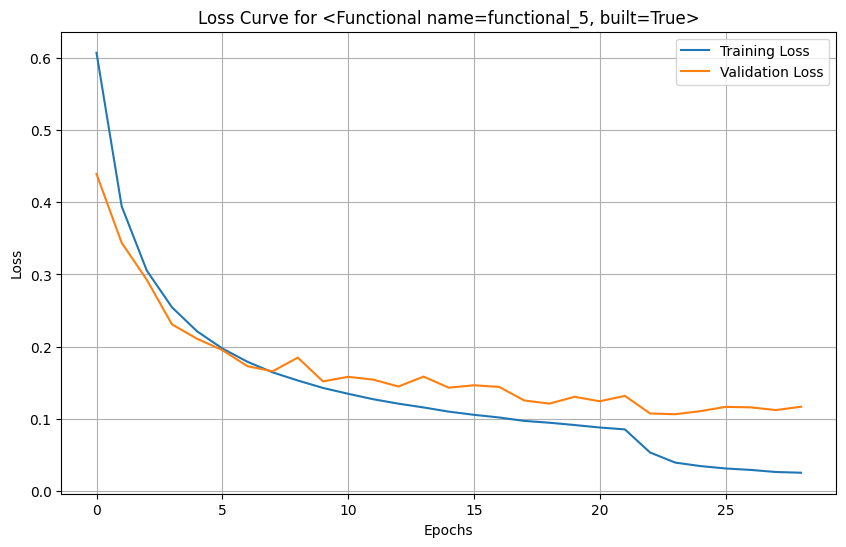

In [ ]:
plot_loss(history_cnn_res, deeper_cnn)

8321/8321 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
------------*****************------------
Test Loss: 0.1032
Test Precision: 0.9768
Test Recall: 0.9763
Test F1 Score: 0.9762
Test Accuracy: 0.9764


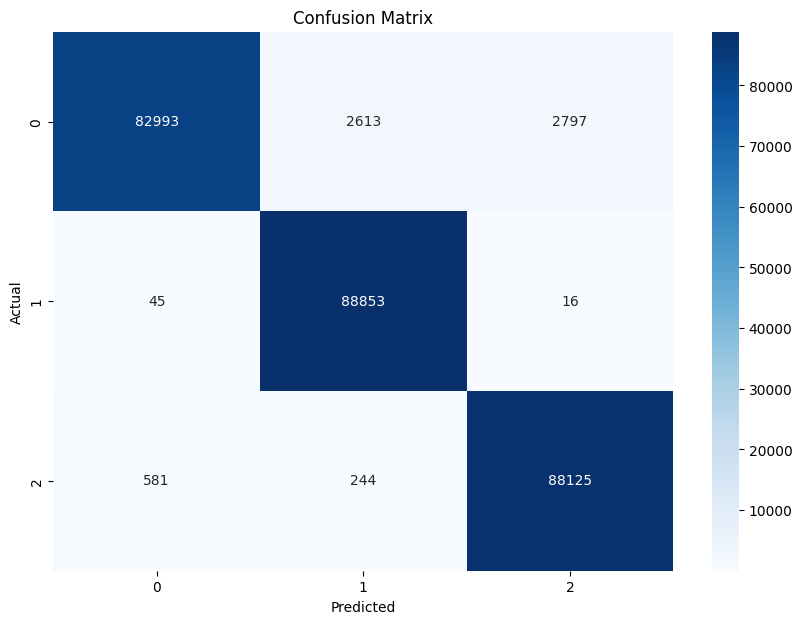

In [ ]:
evaluate(cnn_model, X_test_res, y_test_res, label_maps)

# Hybrid LSTM+ CNN model on oversampled dataset

In [ ]:
from keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Dropout, Dense, Flatten, Concatenate, Input, Bidirectional
from keras.models import Model
from keras.initializers import Constant

def lstm_cnn(max_words, embedding_dim, max_length, num_classes, embedding_matrix_glove):
    """Build the Bidirectional LSTM + CNN model using GloVe embeddings."""

    # Input Layer
    input_layer = Input(shape=(max_length,))

    # Embedding Layer (using pre-trained GloVe embeddings)
    embedding_layer = Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix_glove),
        input_length=max_length,
        trainable=False  # GloVe embeddings are not trainable
    )(input_layer)

    # Apply dropout after embedding
    embedding_dropout = Dropout(0.5)(embedding_layer)

    # Bidirectional LSTM Layer
    lstm_layer = Bidirectional(LSTM(250, return_sequences=True))(embedding_dropout)

    # Convolutional Layers with different filter sizes
    conv_2 = Conv1D(filters=32, kernel_size=2, activation='relu')(lstm_layer)
    conv_3 = Conv1D(filters=32, kernel_size=3, activation='relu')(lstm_layer)
    conv_5 = Conv1D(filters=32, kernel_size=5, activation='relu')(lstm_layer)


    # MaxPooling Layers
    pool_2 = MaxPooling1D(pool_size=2)(conv_2)
    pool_3 = MaxPooling1D(pool_size=2)(conv_3)
    pool_5 = MaxPooling1D(pool_size=2)(conv_3)


    # Flatten the outputs
    flat_2 = Flatten()(pool_2)
    flat_3 = Flatten()(pool_3)
    flat_5 = Flatten()(pool_5)


    # Concatenate the flattened outputs
    concatenated = Concatenate()([flat_2, flat_3,flat_5])

    # Dropout Layer to prevent overfitting
    dropout = Dropout(0.5)(concatenated)

    # Fully Connected Dense Layer
    dense = Dense(128, activation='relu')(dropout)

    # Output Layer (Softmax activation for multi-class classification)
    output_layer = Dense(num_classes, activation='softmax')(dense)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model


In [ ]:
model_name_lstm_cnn_res = "lstm_cnn_hybrid_resample"
base_path = "/content/drive/My Drive/NLP"

In [ ]:
# Build the model
lstm_cnn = lstm_cnn(vocab_size, embedding_dim, input_length, num_classes, embedding_matrix_glove)

# Display the model summary
lstm_cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_22 (Embedding)  │ (None, 100, 100)       │      1,000,000 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 100, 100)       │              0 │ embedding_22[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_24          │ (None, 100, 500)       │        702,000 │ dropout_32[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 99, 32)         │         32,032 │ bidirectional_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 98, 32)         │         48,032 │ bidirectional_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_7           │ (None, 49, 32)         │              0 │ conv1d_15[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_8           │ (None, 49, 32)         │              0 │ conv1d_16[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_9           │ (None, 49, 32)         │              0 │ conv1d_16[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 1568)           │              0 │ max_pooling1d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 1568)           │              0 │ max_pooling1d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 1568)           │              0 │ max_pooling1d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 4704)           │              0 │ flatten_7[0][0],       │
│ (Concatenate)             │                        │                │ flatten_8[0][0],       │
│                           │                        │                │ flatten_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout)      │ (None, 4704)           │              0 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 128)            │        602,240 │ dropout_33[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 3)              │            387 │ dense_37[0][0]         │
└──────────────────────

 Total params: 2,384,691 (9.10 MB)

 Trainable params: 1,384,691 (5.28 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
lstm_cnn, history_lstm_cnn = train(lstm_cnn, model_name_lstm_cnn_res, base_path, X_train_res, y_train_res, X_val_res, y_val_res, learning_rate=1e-3, batch_size=128, epochs=30)


Model 'lstm_cnn_hybrid_resample' loaded from: /content/drive/My Drive/NLP/models/lstm_cnn_hybrid_resample.joblib
Model 'lstm_cnn_hybrid_resample' loaded successfully. Skipping training.
Weights for model 'lstm_cnn_hybrid_resample' loaded from /content/drive/My Drive/NLP/models/lstm_cnn_hybrid_resample.weights.h5.
Training history for 'lstm_cnn_hybrid_resample' loaded successfully.


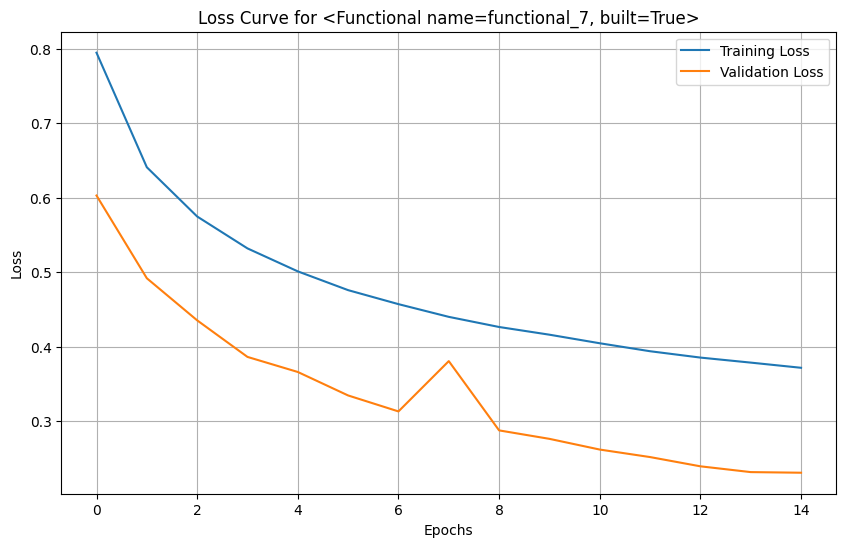

In [ ]:
plot_loss(history_lstm_cnn, lstm_cnn)

8321/8321 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step
------------*****************------------
Test Loss: 0.2294
Test Precision: 0.9199
Test Recall: 0.9188
Test F1 Score: 0.9190
Test Accuracy: 0.9189


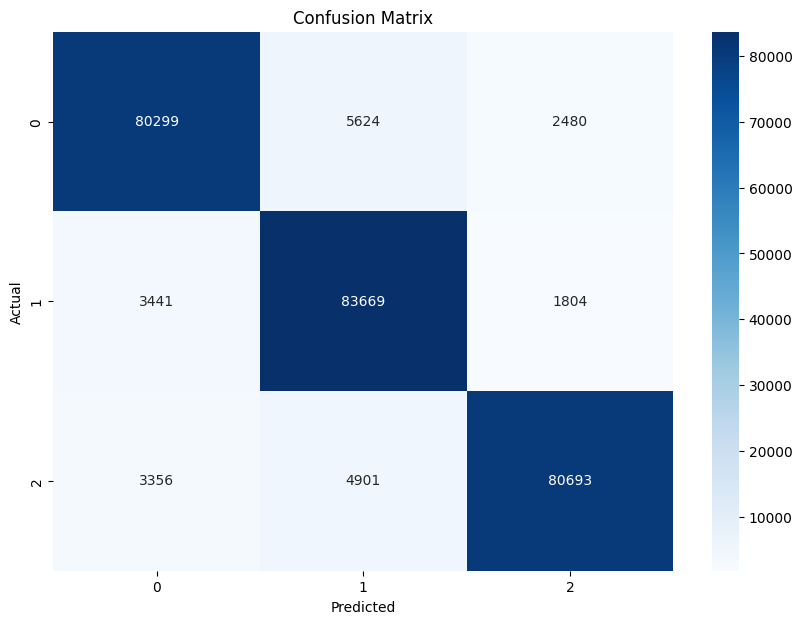

In [ ]:
evaluate(lstm_cnn, X_test_res, y_test_res, label_maps)